Code to read survey results

Number of participants by region and language used.
The type of sample method used in the survey (simple, complex, etc.).
What is the survey representative of when you use the sample weights and when you don’t use the sample weights. This could be country, household, or individual.
The questions you would like to use in the thesis together with some descriptive statistics (for this you can omit considering the sample design and weights):
type of data: dichotomous; categorical (which categories); continuous (which range); open question (which language).
Correlation analysis

In [2]:
import pandas as pd
import numpy as np
import openpyxl

In [3]:
survey_questions  = pd.read_csv('ESS_files\ESS10.csv', low_memory=False)
# Clean the survey questions dataframe to make it more usable for mapping
survey_questions.set_index('idno', inplace=True)

In [4]:
from bs4 import BeautifulSoup
import pandas as pd

# Define the path to the HTML file
html_file_path = 'ESS_files/ESS10 codebook.html'

# Initialize a list to hold the rows of the DataFrame
rows = []

# Read the HTML file
with open(html_file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content
soup = BeautifulSoup(html_content, 'lxml')

# Find all <h3> tags with an 'id' attribute (these contain the questions)
question_tags = soup.find_all('h3', id=True)

# Iterate over the question tags to extract the details
for tag in question_tags:
    idnumber = tag.get('id')  # Get the ID of the question
    questiontext = tag.find_next_sibling('div').text.strip()  # Get the question text
    
    # Find the next div that possibly contains the table
    table_container = tag.find_next_sibling('div').find_next_sibling('div')
    if table_container:
        table = table_container.find('table')
    else:
        table = None

    # Initialize an empty list to hold the response options
    responseoptions = []

    # If a table is found, extract options
    if table:
        for row in table.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) == 2:  # Ensure exactly 2 cells are found (value and description)
                value = cells[0].text.strip()
                description = cells[1].text.strip()
                responseoptions.append(f"{value}: {description}")

    # Convert the list of response options to a string
    responseoptions_str = "; ".join(responseoptions)

    # Append the extracted information as a row to the rows list
    rows.append({
        'id': idnumber,
        'questiontext': questiontext,
        'responseoptions': responseoptions_str
    })

# Create a DataFrame from the rows list
ESSQuestionData = pd.DataFrame(rows)
ESSQuestionData["question_answers_combined"] = ESSQuestionData['questiontext'] + ESSQuestionData['responseoptions']
# Save the DataFrame to a CSV file
ESSQuestionData.to_csv("ESSQuestionData.csv", index=False)
ESSQuestionData

,id,questiontext,responseoptions,question_answers_combined
0,name,Title of dataset,,Title of dataset
1,essround,ESS round,,ESS round
2,edition,Edition,,Edition
3,proddate,Production date,,Production date
4,idno,Respondent's identification number,,Respondent's identification number
...,...,...,...,...
613,mode,Mode of data collection,"1: Interview, Face to face (CAPI); 2: Intervie...","Mode of data collection1: Interview, Face to f..."
614,domain,Sampling domain,,Sampling domain
615,prob,Sampling probability,,Sampling probability
616,stratum,Sampling stratum,,Sampling stratum


Time to categorize questions using BERT!

In [73]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import torch
import pandas as pd

In [88]:
# Load the additional labeled examples provided for training the BERT model
training_data_path = 'adico_training_data.csv'
training_data = pd.read_csv(training_data_path).drop("Unnamed: 0", axis=1)

# Display the first few rows of the dataframe to understand its structure and labels
# training_data.head(), training_data.columns

training_data_resampled = pd.DataFrame(columns=training_data.columns)
for category in training_data['question_answers_combined'].unique():
    filtered_data = training_data[training_data['question_answers_combined'] == category]
    sample = filtered_data.sample(n=min(20, len(filtered_data)))
    
    training_data_resampled = pd.concat([training_data_resampled, sample])

In [76]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode sequences in the DataFrame
def encode_data(df):
    return tokenizer(df['question_answers_combined'].tolist(), add_special_tokens=True, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Encode the data
encoded_data = encode_data(training_data_resampled)

# Convert the dictionary of tensors into a list of dictionaries for each example
encoded_data = [{key: value[i] for key, value in encoded_data.items()} for i in range(encoded_data['input_ids'].shape[0])]

# Convert ADICO categories to numerical labels
labels_to_ids = {label: idx for idx, label in enumerate(training_data_resampled['ADICO_Category'].unique())}
ids_to_labels = {idx: label for label, idx in labels_to_ids.items()}
labels = training_data_resampled['ADICO_Category'].replace(labels_to_ids).values

# Split the data into training and validation sets
train_encodings, val_encodings, train_labels, val_labels = train_test_split(
    encoded_data, 
    labels, 
    test_size=0.1,
    random_state=42
)

# Prepare a PyTorch dataset
class ADICODataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: self.encodings[idx][key].clone().detach() for key in self.encodings[idx]}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)



# Create dataset instances
train_dataset = ADICODataset(train_encodings, train_labels)
val_dataset = ADICODataset(val_encodings, val_labels)

# # Check the dataset and encoding
# print(train_dataset[0], labels_to_ids)


In [77]:
# Assuming the datasets are already created and the tokenizer is loaded
# Load pre-trained BERT model for sequence classification with the correct number of labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

# Setup training arguments
training_args = TrainingArguments(
    output_dir='./results',          # directory to save output files
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluation is done at the end of each epoch
    save_strategy="epoch"            # model checkpoint saving
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

# Train the model
trainer.train()

# You can save the final model and tokenizer for later use
model_path = './bert-adico-classifier-resampled'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\coolg\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

{'loss': 1.6338, 'grad_norm': 10.953563690185547, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.4}
{'loss': 1.5868, 'grad_norm': 10.28730297088623, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.8}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.5306823253631592, 'eval_runtime': 9.7806, 'eval_samples_per_second': 2.249, 'eval_steps_per_second': 0.204, 'epoch': 1.0}
{'loss': 1.4839, 'grad_norm': 9.176613807678223, 'learning_rate': 3e-06, 'epoch': 1.2}
{'loss': 1.3767, 'grad_norm': 7.73770809173584, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.6}
{'loss': 1.2704, 'grad_norm': 9.309700012207031, 'learning_rate': 5e-06, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2386239767074585, 'eval_runtime': 9.8383, 'eval_samples_per_second': 2.236, 'eval_steps_per_second': 0.203, 'epoch': 2.0}
{'loss': 1.0772, 'grad_norm': 7.889075756072998, 'learning_rate': 6e-06, 'epoch': 2.4}
{'loss': 1.011, 'grad_norm': 13.672643661499023, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.8}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0347317457199097, 'eval_runtime': 10.0065, 'eval_samples_per_second': 2.199, 'eval_steps_per_second': 0.2, 'epoch': 3.0}
{'train_runtime': 830.9148, 'train_samples_per_second': 0.715, 'train_steps_per_second': 0.09, 'train_loss': 1.3164060401916504, 'epoch': 3.0}


('./bert-adico-classifier-resampled\\tokenizer_config.json',
 './bert-adico-classifier-resampled\\special_tokens_map.json',
 './bert-adico-classifier-resampled\\vocab.txt',
 './bert-adico-classifier-resampled\\added_tokens.json')

In [78]:
# Load the saved model and tokenizer
model_path = './bert-adico-classifier-resampled' #condition heavy version: './bert-adico-classifier'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load the CSV file
data_path = 'ESSQuestionData.csv'  # Update this path accordingly
ESSQuestionData = pd.read_csv(data_path)
ESSQuestionData['ADICO_category'] = ""

def predict_adico_categories(texts):
    # Tokenize and prepare the data
    encoded_batch = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    
    # Move model to evaluation mode
    model.eval()
    model.to('cpu')  # Use CPU for inference

    # Make predictions
    with torch.no_grad():
        outputs = model(**encoded_batch)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    
    # Get the highest probability label for each text
    predicted_indices = torch.argmax(predictions, dim=1).numpy()
    predicted_labels = [ids_to_labels[idx] for idx in predicted_indices]
    return predicted_labels

In [79]:
# Assuming you want to process the DataFrame in batches of 20 rows
batch_size = 20

def get_labels(prediction_indices):
    return [ids_to_labels[idx] for idx in prediction_indices]



for i in range(0, 618, batch_size):
    # Define the end index of the batch, making sure not to go out of bounds
    end = i + batch_size if (i + batch_size) <= len(ESSQuestionData) else len(ESSQuestionData)

    # Select the batch
    batch_ESSQuestionData = ESSQuestionData.iloc[i:end]

    # Assuming 'texts' is a list of strings
    texts = batch_ESSQuestionData['question_answers_combined'].tolist()

    # Predict categories in batches
    predicted_labels = predict_adico_categories(texts)

    # Update DataFrame with new column for predicted categories
    ESSQuestionData.loc[i:end-1, 'ADICO_category'] = predicted_labels
    

In [93]:
training_data_resampled[training_data_resampled['ADICO_Category'] == 'Potential Shared Strategy '].at[37,'question_answers_combined']

'Please think back to when you were searching for a place to live. What were the principle factors that influenced your decisions in selecting a home?Natural hazards at a former place of residence No; Yes'

In [94]:
ESSQuestionData[ESSQuestionData['ADICO_category'] == 'Potential Shared Strategy ']

,id,questiontext,responseoptions,question_answers_combined,ADICO_category
2,edition,Edition,NaN,Edition,Potential Shared Strategy
3,proddate,Production date,NaN,Production date,Potential Shared Strategy


Maybe with Cohere it works better

In [3]:
import cohere
from cohere import ClassifyExample
import pandas as pd
import random
import json
cohereKey = "YPOV5Eud45eYSDtQUxsHUERJVWwHGXotsogyzH5j"
co = cohere.Client(cohereKey)

In [99]:
# Assuming survey_questions is your DataFrame
examples = []

for label in training_data['ADICO_Category'].unique():
    for index, row in training_data[training_data['ADICO_Category'] ==  label].sample(5).iterrows():
        text = row['question_answers_combined']
        examples.append(ClassifyExample(text=text, label=label))

In [100]:
len(ESSQuestionData['question_answers_combined'])

618

In [103]:
response = co.classify(
    inputs=["text, hello", "other option"],
    examples=examples,
)

In [106]:
response

ClassifyResponse(id='b6893ce5-ae86-4f53-b34b-8c5e3a7bc425', classifications=[ClassifyResponseClassificationsItem(id='5762d93a-37d0-4f67-887f-07097c53942c', input='text, hello', prediction='Condition', predictions=['Condition'], confidence=0.7318298, confidences=[0.7318298], labels={'Aim/Condition': ClassifyResponseClassificationsItemLabelsValue(confidence=0.075184554), 'Attribute': ClassifyResponseClassificationsItemLabelsValue(confidence=0.13105418), 'Attribute/Condition': ClassifyResponseClassificationsItemLabelsValue(confidence=0.055691667), 'Condition': ClassifyResponseClassificationsItemLabelsValue(confidence=0.7318298), 'Potential Shared Strategy ': ClassifyResponseClassificationsItemLabelsValue(confidence=0.00623977)}, classification_type='single-label'), ClassifyResponseClassificationsItem(id='d03b613b-2666-42e8-a0d8-fda58a6e225f', input='other option', prediction='Condition', predictions=['Condition'], confidence=0.67536587, confidences=[0.67536587], labels={'Aim/Condition': C

In [107]:
# Extracting all predictions and their respective confidences
predictions = [(item.prediction, item.confidence) for item in response.classifications]

# If you need more details, such as the confidence for each possible label
detailed_predictions = [{
    'input': item.input,
    'prediction': item.prediction,
    'confidence': item.confidence,
    'label_confidences': {label: value.confidence for label, value in item.labels.items()}
} for item in response.classifications]

In [108]:
predictions

[('Condition', 0.7318298), ('Condition', 0.67536587)]

In [109]:
questions = ESSQuestionData['question_answers_combined'].tolist()
text_count = len(questions)

# Assuming you want to process the DataFrame in batches of 20 rows
batch_size = 60

for i in range(0, text_count, batch_size):
    # Define the end index of the batch, making sure not to go out of bounds
    end = i + batch_size if (i + batch_size) <= text_count else text_count

    # Select the batch
    batch = questions[i:end]

    response = co.classify(
      inputs=batch,
      examples=examples,
    )

    # Extracting all predictions and their respective confidences
    predicted_labels = [item.prediction for item in response.classifications]


    # Update DataFrame with new column for predicted categories
    ESSQuestionData.loc[i:end-1, 'ADICO_category'] = predicted_labels


Text: End of section B
Classification: Condition
Text: End of section C
Classification: Condition
Text: End of section D
Classification: Condition
Text: End of section F
Classification: Attribute
Text: End of section G
Classification: Condition
Text: End of section H
Classification: Condition
Text: End of section I
Classification: Condition
Text: End of section K
Classification: Condition
Text: End of section V
Classification: Condition
Text: End of interview
Classification: Condition
Text: Start of section J
Classification: Attribute
Text: End of section J
Classification: Condition
Text: Interview length in minutes, main questionnaire
Classification: Attribute
Text: Mode of data collection1: Interview, Face to face (CAPI); 2: Interview, Video (web based); 3: Self completion, Self administered web based questionnaire (CAWI); 4: Self completion, Self administered paper questionnaire; 9: Not available*
Classification: Attribute
Text: Sampling domain
Classification: Condition
Text: Sampli

In [116]:
# Save the updated DataFrame to a new CSV file
ESSQuestionData_path = 'ESSQuestionData.csv'  # Update this path accordingly
ESSQuestionData.to_csv(ESSQuestionData_path, index=False)

ESSQuestionData.sample(10)

,id,questiontext,responseoptions,question_answers_combined,ADICO_category
608,vinwe,End of section V,NaN,End of section V,Condition
457,fampref,"Preference settings, how familiar",1: Not at all familiar; 2: Not very familiar; ...,"Preference settings, how familiar1: Not at all...",Attribute
290,edlvdahu,"Highest level of education, Hungary",1: Nem járt iskolába; 1-3 osztályos elemi isko...,"Highest level of education, Hungary1: Nem járt...",Attribute
558,panresmo,How important to restrict people's movement be...,0: Not at all important; 1: 1; 2: 2; 3: 3; 4: ...,How important to restrict people's movement be...,Condition
168,lnghom1,Language most often spoken at home: first ment...,AAR: Afar; ABK: Abkhazian; ACE: Achinese; ACH:...,Language most often spoken at home: first ment...,Attribute
240,gndr12,Gender of twelfth person in household,1: Male; 2: Female; 6: Not applicable*; 7: Ref...,Gender of twelfth person in household1: Male; ...,Attribute
87,stflife,How satisfied with life as a whole,0: Extremely dissatisfied; 1: 1; 2: 2; 3: 3; 4...,How satisfied with life as a whole0: Extremely...,Attribute
86,lrscale,Placement on left right scale,0: Left; 1: 1; 2: 2; 3: 3; 4: 4; 5: 5; 6: 6; 7...,Placement on left right scale0: Left; 1: 1; 2:...,Condition
260,rshipa6,Sixth person in household: relationship to res...,1: Husband/wife/partner; 2: Son/daughter/step/...,Sixth person in household: relationship to res...,Attribute
406,edlvfdmk,"Father's highest level of education, North Mac...",1: Bez obrazovanie; 2: Chetvrto/petto oddeleni...,"Father's highest level of education, North Mac...",Attribute


In [4]:
ESSQuestionData_path = 'ESSQuestionData.csv'  # Update this path accordingly

ESSQuestionData = pd.read_csv(ESSQuestionData_path)

In [5]:
ESSQuestionData.set_index('id', inplace=True)
# Filter out questions that are categorized as Attributes, Conditions, or Aims for clarity in analysis
Attributes = ESSQuestionData.loc[ESSQuestionData['ADICO_category'].str.contains('Attribute', na=False), 'question_answers_combined']
Conditions = ESSQuestionData.loc[ESSQuestionData['ADICO_category'].str.contains('Condition', na=False), 'question_answers_combined']
Aims = ESSQuestionData.loc[ESSQuestionData['ADICO_category'].str.contains('Aim', na=False), 'question_answers_combined']
# Attcons = list(set([Attcon for Attcon in ESSQuestionData[ESSQuestionData['ADICO_Category'].isin(["Attribute", "Condition",'Aim/Condition', "Attribute/Condition"])]['question_answers_combined']]))

# chosen_aims = ["R06a_media_freq",  "R2_implementation_NM4", "R2_implementation_NM5", "R2_implementation_SM3"]

In [6]:
for aim in Aims: print(aim)

Signed petition last 12 months1: Yes; 2: No; 7: Refusal*; 8: Don't know*; 9: No answer*
Boycotted certain products last 12 months1: Yes; 2: No; 7: Refusal*; 8: Don't know*; 9: No answer*
European Union: European unification go further or gone too far0: Unification already gone too far; 1: 1; 2: 2; 3: 3; 4: 4; 5: 5; 6: 6; 7: 7; 8: 8; 9: 9; 10: Unification go further; 77: Refusal*; 88: Don't know*; 99: No answer*
In country government sticks to policies regardless of what most people think0: Never; 1: 1; 2: 2; 3: 3; 4: 4; 5: 5; 6: 6; 7: 7; 8: 8; 9: 9; 10: Always; 66: Not applicable*; 77: Refusal*; 88: Don't know*; 99: No answer*
COVID-19 vaccine approved by national regulatory authority and available to the public in country1: Yes; 2: No; 9: Not available*
Whether respondent will get vaccinated against COVID-19 with vaccine approved by the national regulatory authority in country1: Yes, I will; 2: Yes, I already have; 3: No; 6: Not applicable*; 7: Refusal*; 8: Don't know*; 9: No answer*


In [129]:
survey_questions

,name,essround,edition,proddate,cntry,dweight,pspwght,pweight,anweight,nwspol,...,vinwe,inwde,jinws,jinwe,inwtm,mode,domain,prob,stratum,psu
idno,,,,,,,,,,,,,,,,,,,,,
10038,ESS10e03_2,10,3.2,02.11.2023,BE,0.882220,0.972276,0.718075,0.698167,30,...,2022-09-01 17:47:00,2022-09-01 17:47:00,2022-09-01 17:47:00,2022-09-01 17:47:00,36.0,1,1.0,0.000397,188,2596
10053,ESS10e03_2,10,3.2,02.11.2023,BE,1.047643,0.888635,0.718075,0.638107,10,...,2022-04-08 11:07:00,2022-04-08 11:10:00,2022-04-08 11:07:00,2022-04-08 11:10:00,54.0,2,2.0,0.000334,194,2206
10055,ESS10e03_2,10,3.2,02.11.2023,BE,1.087741,0.722811,0.718075,0.519033,150,...,2022-05-20 11:08:00,2022-05-20 11:10:00,2022-05-20 11:08:00,2022-05-20 11:10:00,77.0,1,2.0,0.000322,198,2114
10062,ESS10e03_2,10,3.2,02.11.2023,BE,0.909910,1.005565,0.718075,0.722072,15,...,2022-05-22 13:58:00,2022-05-22 13:59:00,2022-05-22 13:58:00,2022-05-22 13:59:00,55.0,1,1.0,0.000385,150,2645
10064,ESS10e03_2,10,3.2,02.11.2023,BE,0.918949,0.638705,0.718075,0.458639,60,...,2022-05-18 11:44:00,2022-05-18 11:45:00,2022-05-18 11:44:00,2022-05-18 11:45:00,55.0,1,1.0,0.000381,149,2313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27808,ESS10e03_2,10,3.2,02.11.2023,SK,0.515714,0.339385,0.323800,0.109893,120,...,2021-06-08 14:28:34,2021-06-08 14:30:41,2021-06-08 14:29:01,2021-06-08 14:31:44,70.0,1,1.0,0.001522,2610,27206
27826,ESS10e03_2,10,3.2,02.11.2023,SK,0.297974,0.196093,0.323800,0.063495,90,...,2021-08-02 10:33:27,2021-08-02 10:36:27,2021-08-02 10:35:22,2021-08-02 10:37:34,45.0,1,2.0,0.002635,2610,27217
27834,ESS10e03_2,10,3.2,02.11.2023,SK,0.965931,0.857000,0.323800,0.277497,30,...,2021-06-26 20:52:15,2021-06-26 20:53:05,2021-06-26 20:52:27,2021-06-26 20:54:32,33.0,1,1.0,0.000813,2631,27134


,questiontext,responseoptions,question_answers_combined,ADICO_category
id,,,,
nwspol,"News about politics and current affairs, watch...",7777: Refusal*; 8888: Don't know*; 9999: No an...,"News about politics and current affairs, watch...",Attribute
netusoft,"Internet use, how often",1: Never; 2: Only occasionally; 3: A few times...,"Internet use, how often1: Never; 2: Only occas...",Attribute
netustm,"Internet use, how much time on typical day, in...",6666: Not applicable*; 7777: Refusal*; 8888: D...,"Internet use, how much time on typical day, in...",Attribute
ppltrst,Most people can be trusted or you can't be too...,0: You can't be too careful; 1: 1; 2: 2; 3: 3;...,Most people can be trusted or you can't be too...,Condition
pplfair,"Most people try to take advantage of you, or t...",0: Most people try to take advantage of me; 1:...,"Most people try to take advantage of you, or t...",Condition
...,...,...,...,...
mode,Mode of data collection,"1: Interview, Face to face (CAPI); 2: Intervie...","Mode of data collection1: Interview, Face to f...",Attribute
domain,Sampling domain,NaN,Sampling domain,Condition
prob,Sampling probability,NaN,Sampling probability,Condition


In [179]:
# Aims

survey_questions['sgnptit'].unique()

array([1, 2, 8, 7, 9], dtype=int64)

In [177]:
y_pred_en


array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

Signed petition last 12 months1: Yes; 2: No; 7: Refusal*; 8: Don't know*; 9: No answer*


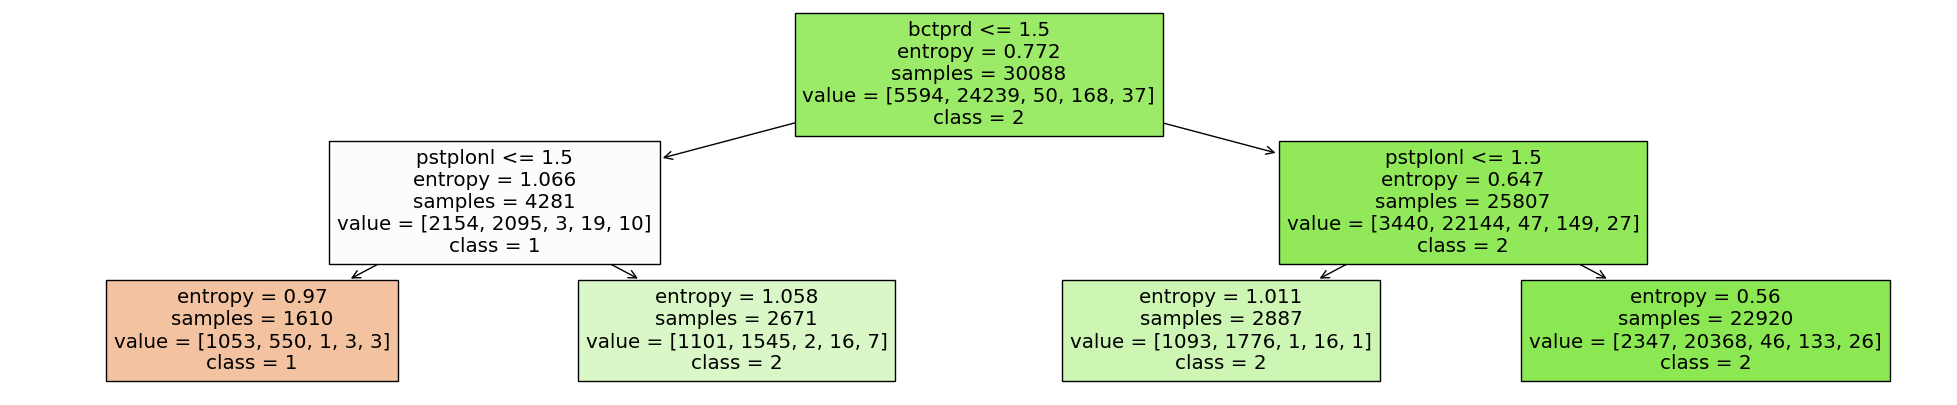

Accuracy is 0.8246710089060215
Boycotted certain products last 12 months1: Yes; 2: No; 7: Refusal*; 8: Don't know*; 9: No answer*


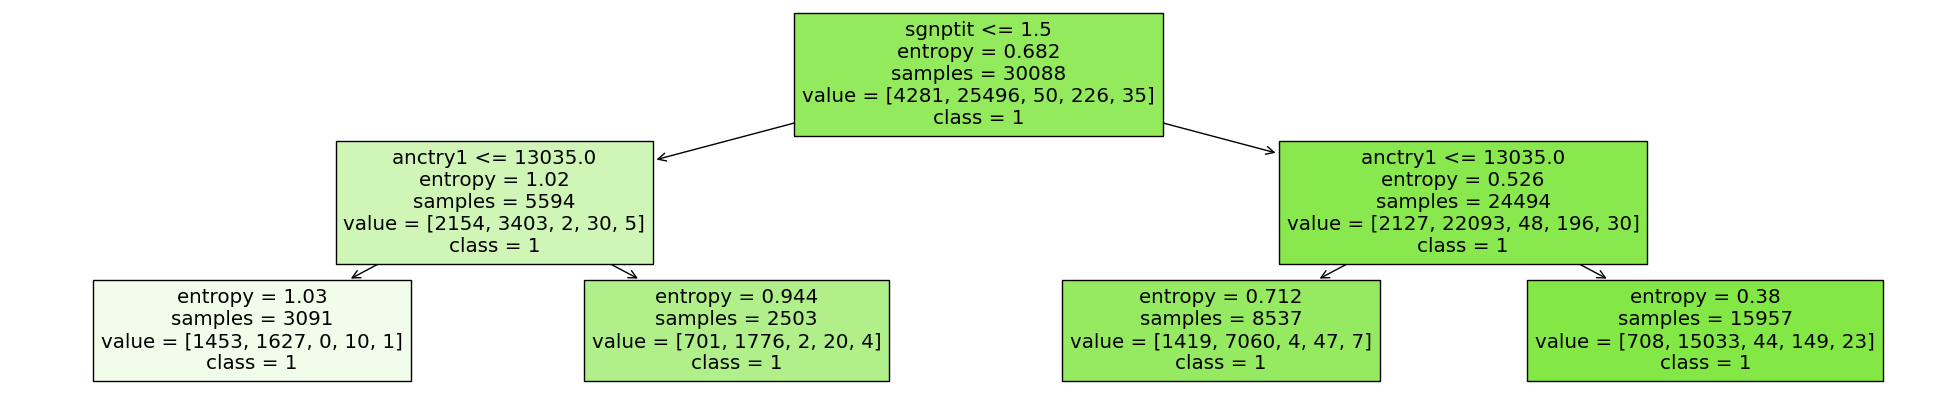

Accuracy is 0.8460720457264389
European Union: European unification go further or gone too far0: Unification already gone too far; 1: 1; 2: 2; 3: 3; 4: 4; 5: 5; 6: 6; 7: 7; 8: 8; 9: 9; 10: Unification go further; 77: Refusal*; 88: Don't know*; 99: No answer*


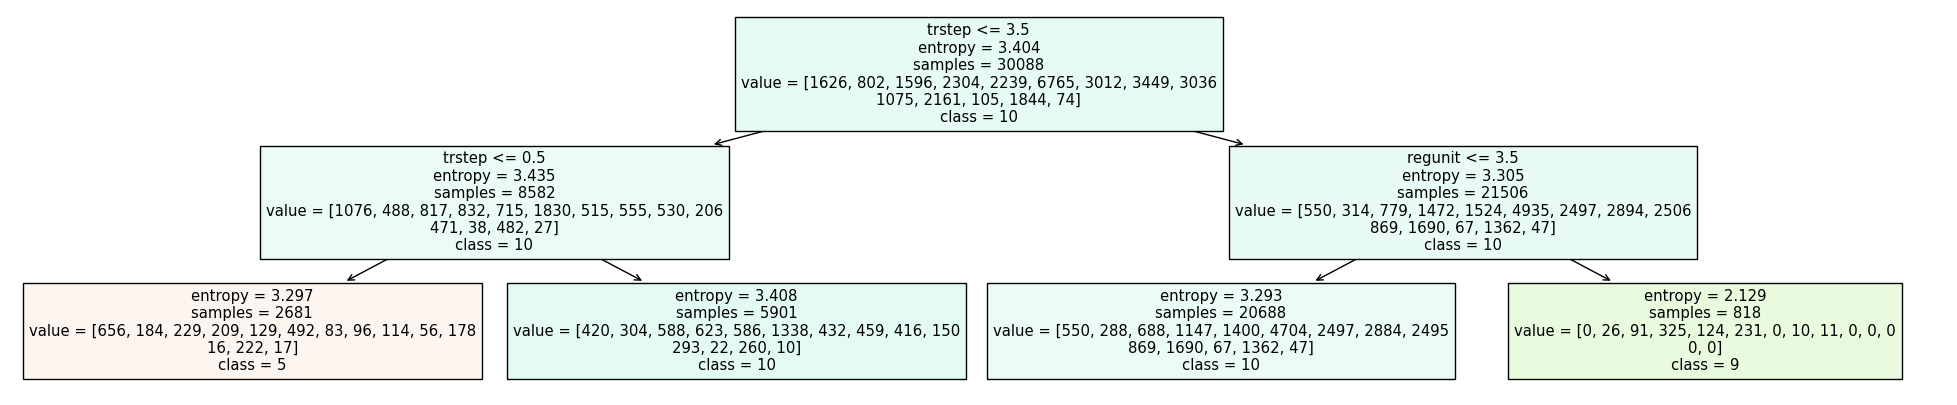

Accuracy is 0.22570782932340822
In country government sticks to policies regardless of what most people think0: Never; 1: 1; 2: 2; 3: 3; 4: 4; 5: 5; 6: 6; 7: 7; 8: 8; 9: 9; 10: Always; 66: Not applicable*; 77: Refusal*; 88: Don't know*; 99: No answer*


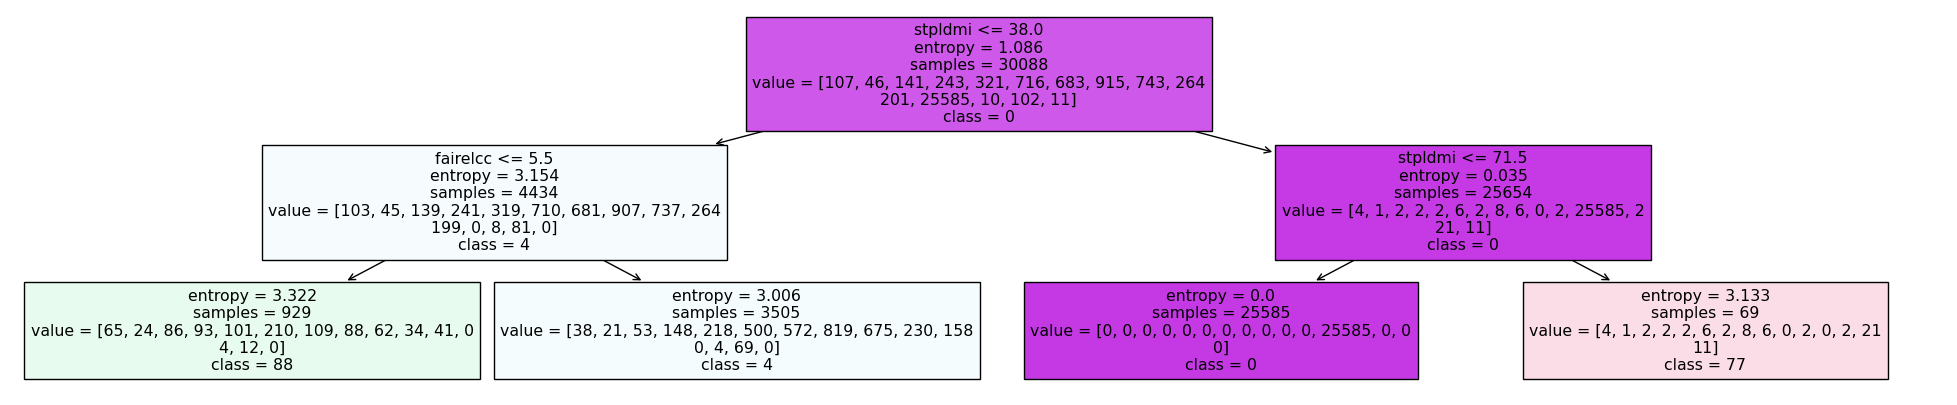

Accuracy is 0.8811644290841419
COVID-19 vaccine approved by national regulatory authority and available to the public in country1: Yes; 2: No; 9: Not available*


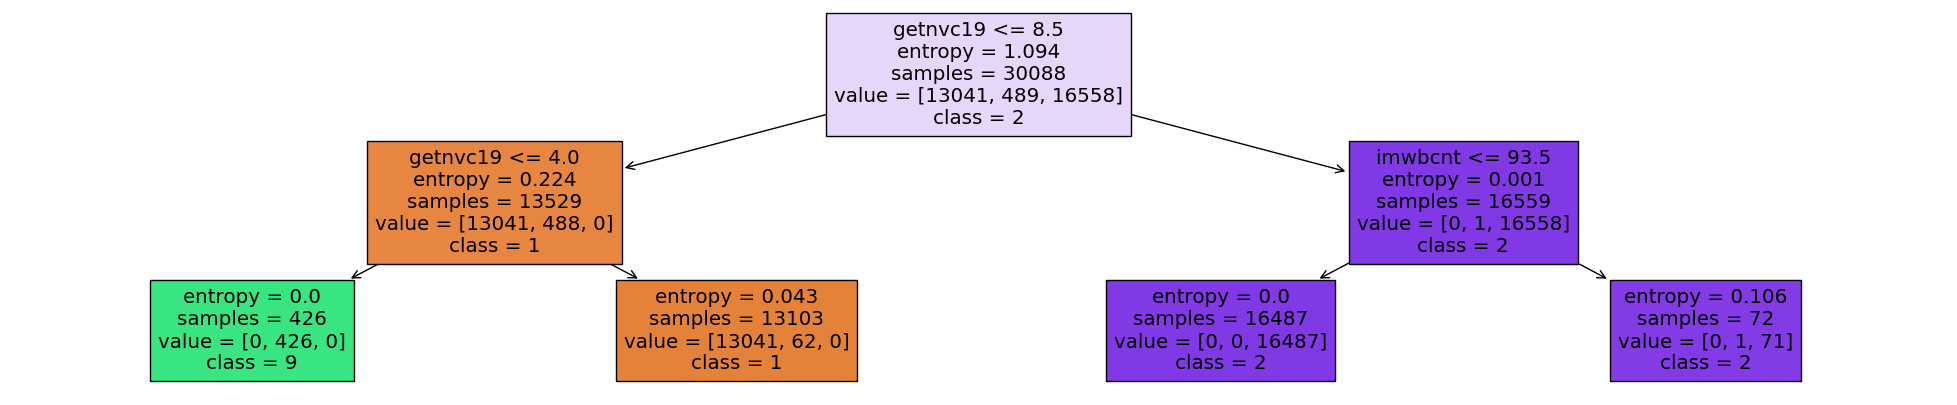

Accuracy is 0.9992024458327795
Whether respondent will get vaccinated against COVID-19 with vaccine approved by the national regulatory authority in country1: Yes, I will; 2: Yes, I already have; 3: No; 6: Not applicable*; 7: Refusal*; 8: Don't know*; 9: No answer*


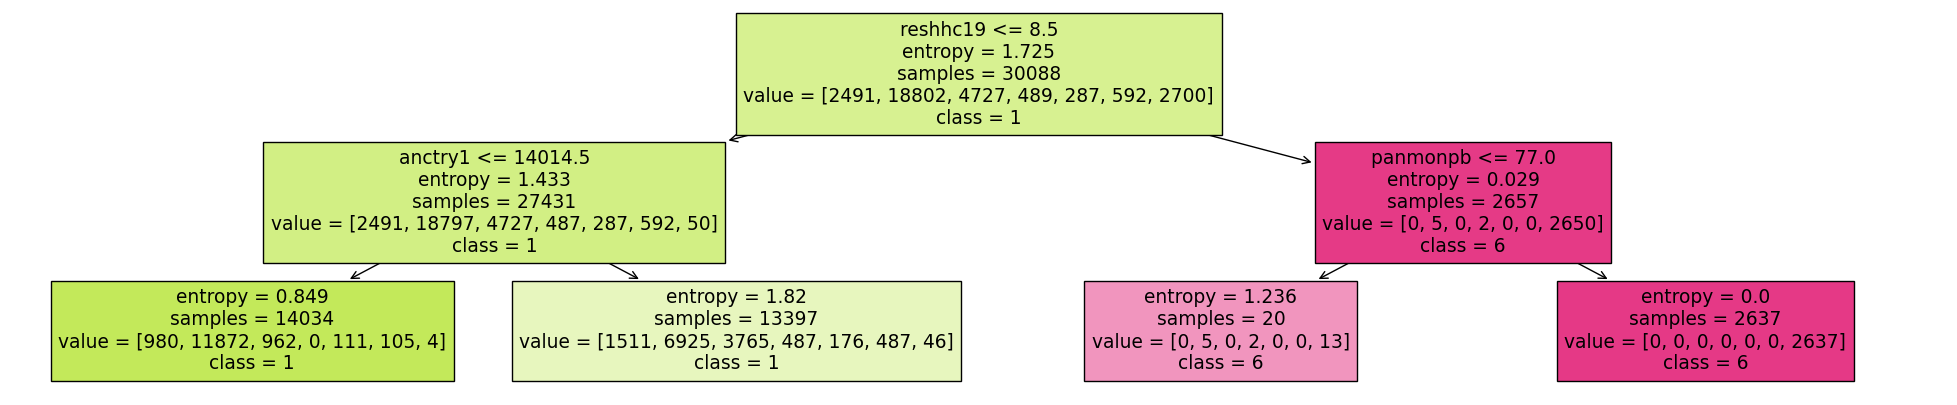

Accuracy is 0.70556958660109
Whether respondent would get vaccinated against COVID-19 if vaccine is approved by the national regulatory authority in country1: Yes, I would; 2: No, I would not; 6: Not applicable*; 7: Refusal*; 8: Don't know*; 9: No answer*


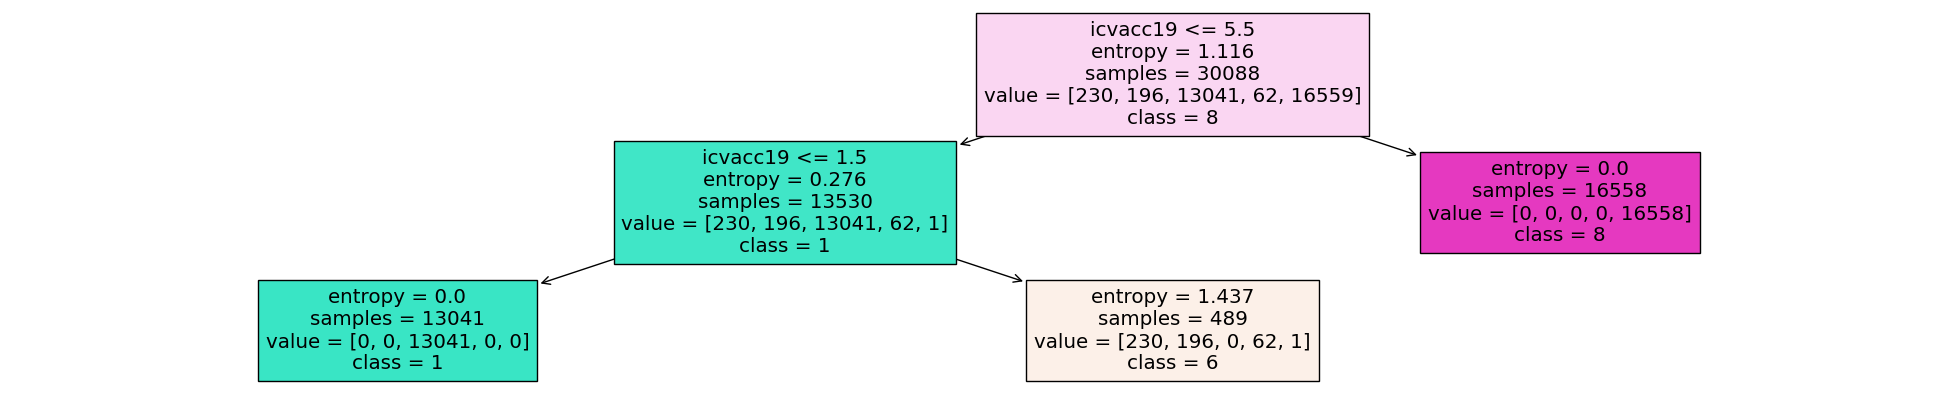

Accuracy is 0.9925561611059418


In [181]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# { 
#     "alg": " HS512"
#     "typ": "JWT"
# }
numerical_answers = survey_questions.iloc[:,10:]

# Try converting each column to numeric and coerce errors to NaN
for column in survey_questions.columns:
    numerical_answers[column] = pd.to_numeric(survey_questions[column], errors='coerce')

# Drop columns that contain any NaN values (i.e., non-convertible columns)
numerical_answers = numerical_answers.dropna(axis=1, how='any')

for aim in Aims.index:
    
    aimRow = str(ESSQuestionData.loc[aim]['question_answers_combined'])
    print(aimRow)

    X = numerical_answers.loc[:, ~numerical_answers.columns.isin([aim])].values
    Y = numerical_answers.loc[:, aim].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)
    clf_entropy = DecisionTreeClassifier(criterion = 'entropy', random_state=100, max_depth=2, min_samples_leaf=20)
    clf_entropy.fit(X_train,y_train)
    # Visualize the decision tree
    plt.figure(figsize=(25,5))
    plot_tree(clf_entropy, filled=True, feature_names=numerical_answers.loc[:, ~numerical_answers.columns.isin([aim])].columns, class_names = [str(item) for item in survey_questions[aim].unique()])
    plt.show()
    y_pred_en = clf_entropy.predict(X_test)
    print(("Accuracy is"),accuracy_score(y_test, y_pred_en))